In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as smapi
from sklearn.metrics import mean_squared_error
import yfinance as yf
import os, contextlib
import glob
from tqdm import tqdm

C:\Users\thopa\AppData\Local\Temp\ipykernel_6900\3081469880.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# # create a folder for data storage
# if not os.path.exists("stocks data"):
#     os.mkdir("stocks data")

# # read the NASDAQ 100 Index ticker symbols list from Wiki
# url = 'https://en.wikipedia.org/wiki/NASDAQ-100#Components'
# html = pd.read_html(url, header=0)
# series = html[4]["Ticker"]
# symbols = series.to_list()
# # download prices history
# with open(os.devnull, 'w') as devnull:
#     with contextlib.redirect_stdout(devnull):
#         for i, symbol in enumerate(symbols):
#             data = yf.download(symbol, period='max')["Close"]
#             data.to_csv('stocks data/{}.csv'.format(symbol))

In [ ]:
path = "stocks_dataCLOSE/"
csv_files = glob.glob(os.path.join(path, "*.csv"))
stocks_dict = {}

# loop over the list of csv files
for f in csv_files:      
    # read the csv file
    df = pd.read_csv(f)
      
    # print the location and filename
    print('Location:', f)
    print('File Name:', f.split("/")[-1])
      
    # print the content
    print('Content:')
    display(df)

In [122]:
# Working with a single stock 
# This signal has 1170 discrete values. We use the LMS algorithm to learn the filter weights 
# Teacher forcing approach at each step 

path = "stocks_dataCLOSE/"
csv_files = glob.glob(os.path.join(path, "GOOGL.csv"))
df = pd.read_csv(csv_files[0])
signal = df['Close']

# Quantizing for more accuracy ?
# Smoothing with an LPF might also work 
signal = [np.floor(i) for i in signal]
signal = np.array(signal)

In [113]:
class lmsPred:
    def __init__(self):
        self.l = 1
        self.u = 2**(-20)
        self.N = 70

        # Weight initialization
        self.wn=np.random.rand(self.N+1,1)/10
          
    def predict(self, x):
        xd= np.block([np.zeros((1,self.l)), x]).T
        y=np.zeros((len(xd),1))
        xn=np.zeros((self.N+1,1))
        xn = np.matrix(xn)
        M=len(xd)
        for n in range(0,M):
            xn = np.block([[xd[n]], [xn[0:self.N]]])
            y[n]= np.matmul(self.wn.T, xn)
            
            if(n>M-self.l-1):
                e =0
            else:
                e=int(x[n]-y[n])
            self.wn = self.wn + 2*self.u*e*xn
        return y

100%|██████████| 4586/4586 [00:05<00:00, 794.72it/s]


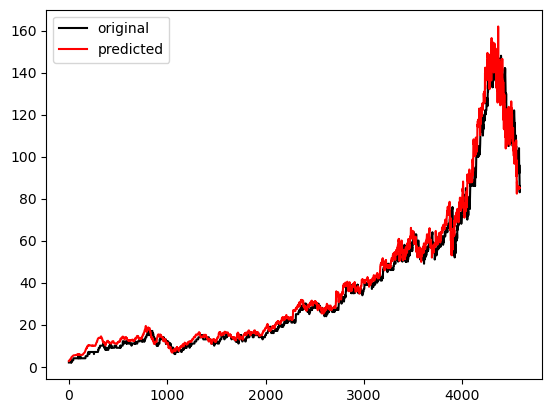

Mean Squared Error:  3.2014774660519008
Mean Absolute Error: 1.5406878733927545


In [123]:
#  Initialize a new LMS predictor class
#  For tuning the hyperparameters 

# Parameters to consider [ u = learning rate, l = number of outputs to predict, N = filter order, x = input vector ]
# Wise to consider a smaller window ~ Ideal window size for stock market prediction


predClass = lmsPred()
x_train = signal
real_values, pred_values = [], []
for i in tqdm(range(len(x_train)-1)):
    x = x_train[i:i+30]
    result = predClass.predict(x)
    pred = result[-1:]
    pred_values.append(np.squeeze(pred))
    real = x[-1]
    real_values.append(x[-1])
    
plt.plot(x_train, color = 'black')
plt.plot(pred_values, color = 'red')
plt.legend(["original", "predicted"])
plt.show()

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Mean Squared Error: ",mean_squared_error(real_values, pred_values) )
print("Mean Absolute Error:", mean_absolute_error(real_values, pred_values))
